In [30]:
import re
import nltk
import spacy
import importlib
import numpy as np
import pandas as pd
from itertools import chain
from wordcloud import WordCloud
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

In [2]:
import utils.db as db

In [ ]:
importlib.reload(db)

In [3]:
conn = db.connect_mongo_db("senate-publication")

In [51]:
publications_cursor = conn.publication.find(projection=["summary", "full_text","type", "normalized_summary"])
publications_df = pd.DataFrame(publications_cursor)
publications_df.head()

,_id,type,summary,full_text,normalized_summary
0,0bf1a75b4a319ba5b920fc946b4e04bd,iniciativas,Propone establecer que las personas jóvenes se...,Página 1 de 16 \nDe la s Senadora s Geovanna d...,proponer establecer persona joven ser encontra...
1,6e9aef9142845000afaed04cfbaf6bd4,iniciativas,Propone atribuir a la Secretaría de Bienestar ...,SENADORAS \nY SENADORES \nTRABAJANDO \nDe las ...,proponer atribuir secretaría bienestar función...
2,c47e1c3be5449bc180c17af4a8b3ca3f,iniciativas,Propone establecer que la Secretaría de Desarr...,Martha Cecilia Márquez Alvarado \nSENADORA DE ...,proponer establecer secretaría desarrollo soci...
3,8f559d4a0d4ca6c4760d744b9de0819c,iniciativas,"Propone reformar el Código Penal Federal, la L...",De la s Senadora Geovanna del Carmen Bañuelos ...,proponer reformar código penal federal ley org...
4,0d635fddff39f7afac40d6cebcd48c47,iniciativas,Propone adicionar el 19 de septiembre de cada ...,ceeaudia 8stller !!Batd~ras 8spinoza \nSENADOR...,proponer adicionar 19 septiembre cada año día ...


## Exploratory analysys

In [77]:
wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3, 
    contour_color='steelblue',
    collocations=True
)

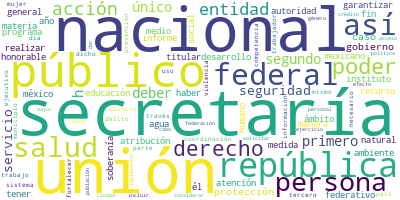

In [93]:
long_string = " ".join(list(publications_df.normalized_summary_v2))
wordcloud.generate(long_string)
wordcloud.to_image()

## Clean text

In [80]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreamarin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
nlp = spacy.load("es_core_news_sm")
stop_words = nltk.corpus.stopwords.words("spanish")

In [94]:
new_stop_words = [
    "senado", "proponer", "exhortar", "comisión", "ser", "congreso", "ley", "establecer", 
    "permanente", "respetuosamente", "unión", "federal", "federativo", "él",
    "primero", "segundo", "reformar", "artículo", "h"
]

In [95]:
stop_words.extend(new_stop_words)

In [96]:
def process_doc(text):
    text = text.lower()
    
    # remove special characters
    text = re.sub("[^a-záéíóúñ\d\s]", "", text, re.A)
    
    # lemmatize text
    nlp_text = nlp(text)
    lemmas = [word.lemma_ for word in nlp_text]
    
    # remove stopwords
    filtered_tokens = [token for token in lemmas if token not in stop_words]
    
    return " ".join(filtered_tokens)

In [97]:
# create vectorized version of function
process_corpus = np.vectorize(process_doc)

In [98]:
# get normalized version of the summary
publications_df["normalized_summary_v2"] = process_corpus(publications_df.summary)

In [58]:
publications_df.head()

,_id,type,summary,full_text,normalized_summary,normalized_summary_v2
0,0bf1a75b4a319ba5b920fc946b4e04bd,iniciativas,Propone establecer que las personas jóvenes se...,Página 1 de 16 \nDe la s Senadora s Geovanna d...,proponer establecer persona joven ser encontra...,persona joven encontrar 18 29 año adulta mayor...
1,6e9aef9142845000afaed04cfbaf6bd4,iniciativas,Propone atribuir a la Secretaría de Bienestar ...,SENADORAS \nY SENADORES \nTRABAJANDO \nDe las ...,proponer atribuir secretaría bienestar función...,atribuir secretaría bienestar función elaborar...
2,c47e1c3be5449bc180c17af4a8b3ca3f,iniciativas,Propone establecer que la Secretaría de Desarr...,Martha Cecilia Márquez Alvarado \nSENADORA DE ...,proponer establecer secretaría desarrollo soci...,secretaría desarrollo social fomentar creación...
3,8f559d4a0d4ca6c4760d744b9de0819c,iniciativas,"Propone reformar el Código Penal Federal, la L...",De la s Senadora Geovanna del Carmen Bañuelos ...,proponer reformar código penal federal ley org...,reformar código penal federal orgánico adminis...
4,0d635fddff39f7afac40d6cebcd48c47,iniciativas,Propone adicionar el 19 de septiembre de cada ...,ceeaudia 8stller !!Batd~ras 8spinoza \nSENADOR...,proponer adicionar 19 septiembre cada año día ...,adicionar 19 septiembre cada año día descanso ...


In [87]:
db.batch_update_publications(
    publications_df.to_dict(orient="records"),
    "publication",
    conn
)

## Create LDA model

In [99]:
publications_words = list(publications_df.normalized_summary_v2.apply(str.split))

In [100]:
dictionary = corpora.Dictionary(publications_words)

# corpus with bag of words
corpus = [dictionary.doc2bow(publication) for publication in publications_words]

In [101]:
num_topics = 10

In [103]:
for num_topics in [3, 5, 7, 10, 15]:

    # lda model
    model = LdaModel(
        corpus, 
        num_topics=num_topics,
        id2word=dictionary, 
        passes=300
    )
    
    print(f"num_topics: {num_topics}")
    for topic in model.print_topics(num_topics=num_topics, num_words=10):
        print(topic)
        
    print("======="*20)

num_topics: 3
(0, '0.021*"salud" + 0.019*"secretaría" + 0.013*"público" + 0.011*"servicio" + 0.010*"nacional" + 0.010*"así" + 0.009*"programa" + 0.009*"educación" + 0.009*"entidad" + 0.008*"federativo"')
(1, '0.021*"república" + 0.015*"secretaría" + 0.014*"nacional" + 0.010*"primero" + 0.010*"único" + 0.010*"h" + 0.009*"segundo" + 0.009*"acción" + 0.009*"protección" + 0.009*"gobierno"')
(2, '0.013*"persona" + 0.012*"poder" + 0.011*"deber" + 0.008*"derecho" + 0.008*"tener" + 0.008*"público" + 0.008*"él" + 0.006*"caso" + 0.006*"materia" + 0.006*"año"')
num_topics: 5
(0, '0.016*"agua" + 0.016*"república" + 0.013*"único" + 0.011*"público" + 0.010*"informe" + 0.010*"primero" + 0.010*"segundo" + 0.009*"secretaría" + 0.009*"servicio" + 0.009*"soberanía"')
(1, '0.016*"educación" + 0.012*"social" + 0.012*"deber" + 0.011*"salud" + 0.011*"público" + 0.010*"servicio" + 0.010*"persona" + 0.010*"nacional" + 0.009*"garantizar" + 0.009*"programa"')
(2, '0.016*"poder" + 0.010*"persona" + 0.009*"él" + 0